## Activation maximization with torch‑lucent

- To see what a feature “likes” in the abstract, rather than on a specific photo, activation maximization is used on the `inception4b` (mixed4b‑like) layer.  
- For each of 10 channels in `inception4b`, a separate synthetic image is optimized so that the activation of that channel becomes large.  
  - The objective targets one channel at a time via `objectives.channel(target_layer, i, batch=0)`.  
  - The optimization iteratively updates the input image (not the model weights) to increase the chosen channel’s activation.  
- The image parameterization uses:
  - `fft=True`: the image is represented in the Fourier domain, encouraging smoother, less noisy patterns.  
  - `decorrelate=True`: color channels are decorrelated to resemble natural‑image statistics, making results more interpretable.

In your results for the first 10 channels of `inception4b`, the activation‑maximized images clearly show diverse **mid‑level textures and parts**:  
- Some channels prefer bubble‑like circles, tiled eye‑like squares, or swirl/spiral patterns.  
- Others prefer cauliflower‑like blobs, wavy bands, stacked ridges, spiky starbursts, cone‑like shapes, or dense curled‑hair textures with small line segments.  
This confirms that `inception4b` has specialized into a rich set of texture and part detectors, with each channel responding strongly to a particular family of shapes and colors.

## Conceptual picture tying it all together

- **Filters (weights)** define what each feature / channel is looking for.  
- **Feature maps (activations)** show where in a particular image those features are present.  
- **Hooks and feature‑map visualizations** show the hierarchy of representations for a given input image, from edges to shapes to object‑like patterns.  
- **Activation maximization with torch‑lucent** shows, for each chosen channel in `inception4b`, a synthetic “prototypical” pattern that most strongly excites that feature, revealing that this mid‑layer is composed of many distinct texture and part detectors.

In [1]:
!pip install torch-lucent

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.5/253.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=525a275e291219772d1e9ab643c57f0242d89f065ab9aaa61758d562e307d8cf
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt


In [2]:
import torch
from torchvision import models
from lucent.optvis import render, param, objectives

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pretrained GoogLeNet (InceptionV1)
weights = models.GoogLeNet_Weights.DEFAULT
model = models.googlenet(weights=weights).to(device)
model.eval()

Using device: cuda
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 155MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
# Fourier + color decorrelation parameterization (Lucent default for nice images)
def param_f():
    return param.image(w=224, h=224, fft=True, decorrelate=True)

In [4]:
# Define the target layer and number of channels to visualize
target_layer = "inception4b"
num_channels_to_visualize = 10  # Visualize the first 10 channels for example

# Prepare a list to store the generated images
list_of_images = []

# Generate an image for each channel individually
for i in range(num_channels_to_visualize):
    # Create an objective for a single channel
    objective = objectives.channel(target_layer, i, batch=0)

    # Render the visualization for this single channel
    images = render.render_vis(
        model,
        objective,
        param_f=param_f,
        show_image=False,
        thresholds=(512,)
    )

    # Add the generated image to our list (images is a list with one item per threshold)
    list_of_images.append(images[0][0]) # Assuming images[0] is the batch, and we take the first (and only) image from it

print(f"Generated {len(list_of_images)} images.")

100%|██████████| 512/512 [00:12<00:00, 40.34it/s]

Generated 10 images.


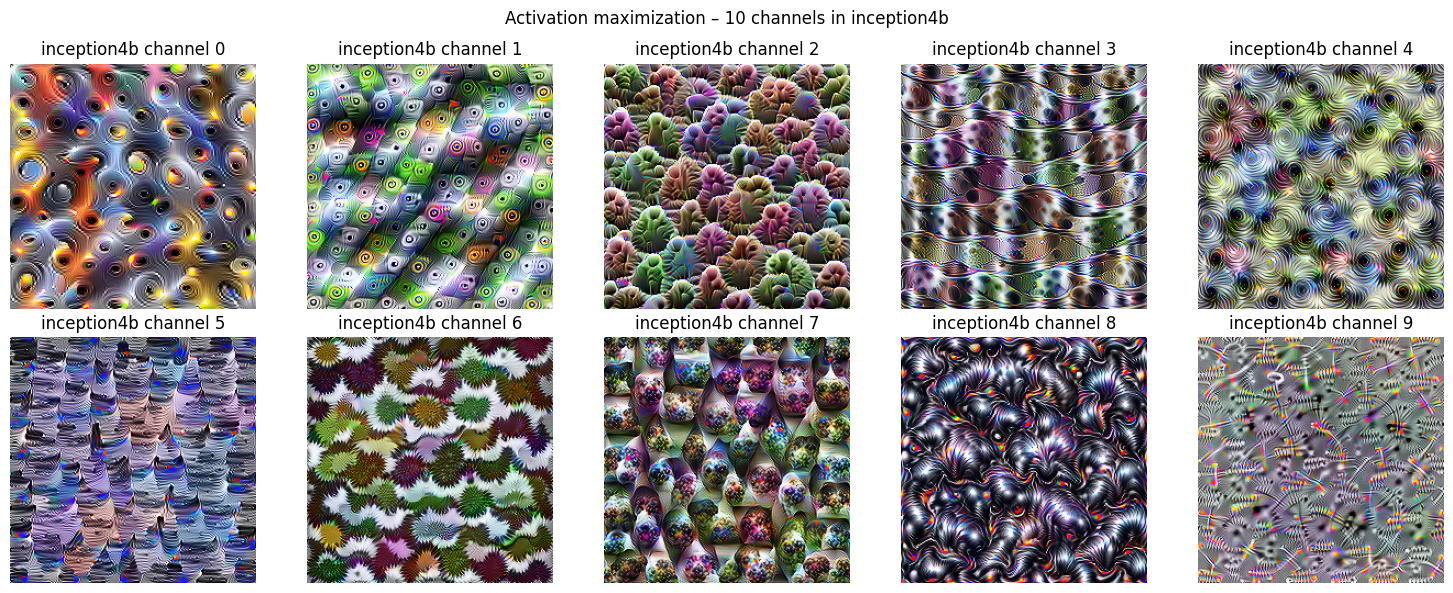

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, img in enumerate(list_of_images):
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(f"{target_layer} channel {i}")
    ax.axis("off")

plt.suptitle(f"Activation maximization – 10 channels in {target_layer}")
plt.tight_layout()
plt.show()